# Generating Objects w/ `Variational Auto Encoder (VAE)`

### Import dependencies

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import ImageDataset
%matplotlib inline

### Load dataset

In [4]:
data_dir = 'datasets/101_ObjectCategories/'
save_file = 'saved/data.pkl'

In [3]:
data = ImageDataset(data_dir=data_dir, size=128, grayscale=False, flatten=True)
data.create()


Processing 102 of 102 class labels & 60 of 60 imagess

In [8]:
# data.save(save_file=save_file, force=True)
# data = data.load(save_file=save_file)

data.images.shape: (9145, 49152)


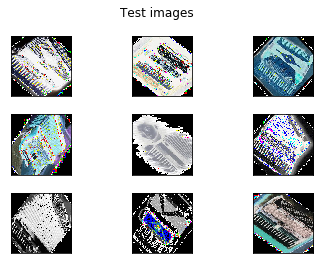

In [9]:
print(f'data.images.shape: {data.images.shape}')
# Plot first 9 images
data.visualize(data.images[:10], name='Test images')

### Hyperparameters

In [11]:
# inputs
img_size = data.size
img_channel = data.channel
img_size_flat = img_size * img_size * img_channel
print(f'Size: {img_size}\tChannel: {img_channel}\tSize flat: {img_size_flat:,}')

Size: 128	Channel: 3	Size flat: 49,152


In [ ]:
# network
hidden_dim = 64
latent_dim = 128
kernel_size = 5
stride = 2